# QBAF-Py: Examples
This noteboook provides some examples for how to use QBAF-Py.

## Instantiating QBAFs
Let us first instantiate a QBAF.

In [1]:
from qbaf import QBAFramework, QBAFARelations

args = ['a', 'b', 'c', 'd', 'e', 'f']
initial_strengths = [0.5, 0.2, 0.85, 0.65, 0.4, 1]
atts = [('c', 'a'), ('e', 'b'), ('f', 'c')]
supps = [('b', 'a'), ('d', 'a'), ('e', 'c')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")


The semantics that will later be applied is tied to the QBAF instantiation.
Here, we specify the quadratic energy semantics.
Note that QBAF-Py is for argumentation-based reasoning and not for visualization, so we have to take care of the visualization ourself; in the function that we implement below, we also take care of the visualization of explanations.

In [2]:
%%capture
# To visualize the QBAFs, the networkx and pygraphviz libraries are required.
# We install them below, but depending on your setup, you may need to install them differently
!pip install networkx
!pip install pygraphviz

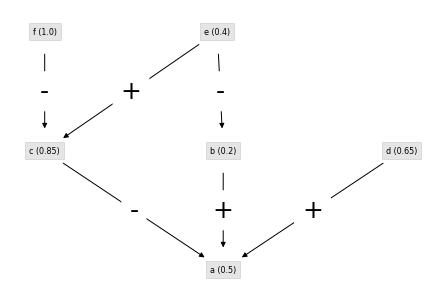

In [3]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


def visualize(qbaf: QBAFramework, explanations=[], with_fs=False, round_to=2):
    """
    Takes a QBAF and renders it as a graph
    
    Args:
            qbaf (QBAFramework): The QBAF that is supposed to be rendered
            explanations (List): List of sets of explanation arguments that are supposed to be highlighted
            with_fs (Bool): Set to `True` if final strenghts should be rendered as well.
                            Defaults to `False`.
            round_to (int): Number of decimals the strengths should be rounded to before rendering.
                            Defaults to `2`.
            
    """
    args = qbaf.arguments
    initial_strengths = qbaf.initial_strengths
    for key, value in initial_strengths.items():
        initial_strengths[key] = round(value, round_to)
    if with_fs:
        final_strengths = qbaf.final_strengths
        for key, value in final_strengths.items():
            final_strengths[key] = round(value, round_to)
    graph = nx.DiGraph()
    nodes = {}
    edge_colors = []
    node_sizes = []
    for arg in args:
        if with_fs:
            label = f'{arg} ({initial_strengths[arg]}): {final_strengths[arg]}'
        else:
            label = f'{arg} ({initial_strengths[arg]})'
        graph.add_node(label)
        nodes[arg] = label
        edge_color = '#fff'
        node_size = 2000
        for explanation in explanations:
            if arg in explanation:
                edge_color = '#af4154'
                node_size = 3000
        node_sizes.append(node_size)
        edge_colors.append(edge_color)
    labels = {}
    for att in qbaf.attack_relations.relations:
        labels[(nodes[att[0]], nodes[att[1]])] = '-'
        graph.add_edge(nodes[att[0]], nodes[att[1]])
    for supp in qbaf.support_relations.relations:
        labels[(nodes[supp[0]], nodes[supp[1]])] = '+'
        graph.add_edge(nodes[supp[0]], nodes[supp[1]])
    pos = graphviz_layout(graph, prog='dot')
    nx.draw(graph, pos, with_labels=True, node_shape='8', node_size=node_sizes, font_size=8, node_color='#fff', edgecolors=edge_colors,bbox=dict(facecolor='black', alpha=0.1))
    nx.draw_networkx_edge_labels(
    graph, pos,
    edge_labels=labels,
    font_size=25,
    rotate=False)

visualize(qbaf_0)


## Drawing Inferences
As we have instantiated our QBAF with a specific semantics, the inferences (final strengths) are readily available:

In [4]:
final_strengths = qbaf_0.final_strengths
print(final_strengths)

{'e': 0.4, 'f': 1.0, 'c': 0.625, 'b': 0.1724137931034483, 'd': 0.65, 'a': 0.5187551724162596}


We update the visualizations to also show the final strengths of the arguments.
For this, we call our visualization function, with the parameter `with_fs` set to `True`.

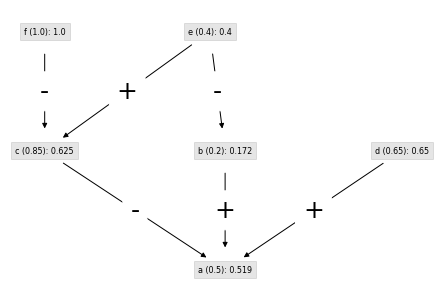

In [5]:
visualize(qbaf_0, with_fs=True, round_to=3)

## Generating Explanations
Given two argumentation frameworks and two arguments therein (so-called *topic arguments*), we can explain changes in the relative strength of these arguments (see: Kampik and Čyras. [Explaining Change in Quantitative Bipolar Argumentation](https://www.diva-portal.org/smash/get/diva2:1690830/FULLTEXT02). First, we instantiate two QBAFs and compute their final strengths; note that here, we use a naive semantics (`basic_model`), which simply subtracts the final strengths of attackers and adds the final strength of supporters.

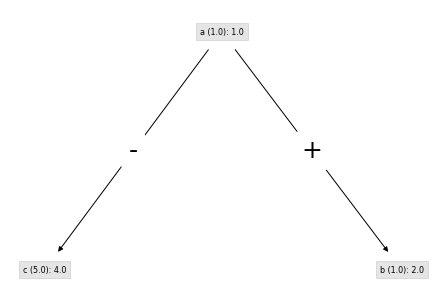

In [6]:
args_1 = ['a', 'b', 'c']
initial_strengths_1 = [1, 1, 5]
atts_1 = [('a', 'c')]
supps_1 = [('a', 'b')]
qbaf_1 = QBAFramework(args_1, initial_strengths_1, atts_1, supps_1, semantics="basic_model")

args_2 = ['a', 'b', 'c', 'd', 'e']
initial_strengths_2 = [2, 1, 5, 1, 3]
atts_2 = [('a', 'c'), ('d', 'a'), ('e', 'c')]
supps_2 = [('a', 'b'), ('d', 'e')]
qbaf_2 = QBAFramework(args_2, initial_strengths_2, atts_2, supps_2, semantics="basic_model")

visualize(qbaf_1, with_fs=True)

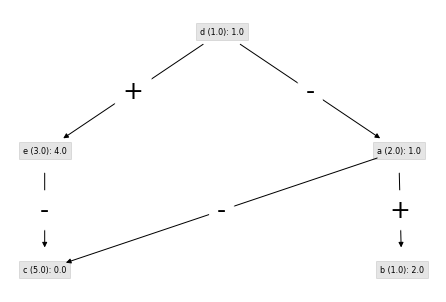

In [7]:
visualize(qbaf_2, with_fs=True)

As we can see, `b` is strength-inconsistent w.r.t. `c` (and `qbaf_1`, `qbaf_2`):

In [8]:
print(f'Are a and b strenght-consistent? {qbaf_1.are_strength_consistent(qbaf_2, "b", "c")}')

Are a and b strenght-consistent? False


Now, we can determine and visualize strength inconsistency explanations.

Minimal sufficient explanations: [{'e'}, {'a'}]


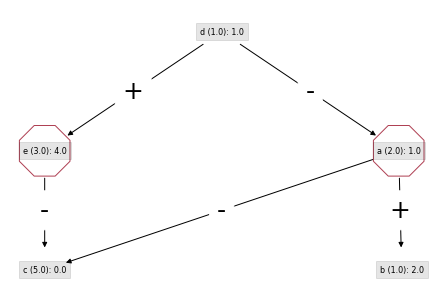

In [9]:
min_sufficient_explanations = qbaf_1.minimalSSIExplanations(qbaf_2, 'b', 'c')
print(f'Minimal sufficient explanations: {min_sufficient_explanations}')
visualize(qbaf_2, explanations=min_sufficient_explanations, with_fs=True)

Minimal counterfactual explanations: [{'e'}]


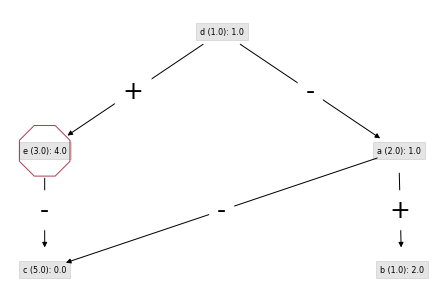

In [10]:
min_counterfactual_explanations = qbaf_1.minimalCSIExplanations(qbaf_2, 'b', 'c')
print(f'Minimal counterfactual explanations: {min_counterfactual_explanations}')
visualize(qbaf_2, explanations=min_counterfactual_explanations, with_fs=True)

## QBAF Arguments
Let us introduce the class QBAFArgument.

Note: Any object that is hashable can be used as argument (string, int, ...).

In [6]:
from qbaf import QBAFArgument

a = QBAFArgument(name='a', description='Shares from company X should be bought')
print(f"{a}")
print(f"{a = }")
print(f'{a.name = }')
print(f'{a.description = }')

Arg('a')
a = 'a'
a.name = 'a'
a.description = 'Shares from company X should be bought'


The attribute name is unmodifiable, whereas the attribute description is optional and modifiable.

In [14]:
b = QBAFArgument('b')
print(f'{b.name = }')

b.description = 'Shares from company X should be sold'
print(f'{b.description = }')

b.name = 'b'
b.description = 'Shares from company X should be sold'


Two arguments are equal iff their names are equal.

In [15]:
print(f'{a == b = }')

print(f"{a == QBAFArgument('a', 'Different description') = }")

a == b = False
a == QBAFArgument('a', 'Different description') = True
